In [8]:
!pip install segment-anything

In [65]:
import os
import glob

# Delete all uploaded files (PNG, JPG, etc.)
for file in glob.glob("*.png"):
    os.remove(file)

print("All .png files deleted.")

All .png files deleted.


In [66]:
from google.colab import files
uploaded = files.upload()

Saving img1.png to img1.png
Saving img2.png to img2.png
Saving mask1.png to mask1.png
Saving mask2.png to mask2.png
Saving masked_img1.png to masked_img1.png
Saving masked_img2.png to masked_img2.png
Saving unseen_img1.png to unseen_img1.png
Saving unseen_img2.png to unseen_img2.png


In [67]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-gvr828ce
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-gvr828ce
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [53]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2025-07-28 01:50:07--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.15, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth.5’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   235MB/s    in 1.5s    

2025-07-28 01:50:09 (235 MB/s) - ‘sam_vit_b_01ec64.pth.5’ saved [375042383/375042383]



In [68]:
# import models and packages needed
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch
import cv2
import numpy as np

In [74]:
# function resizes image. I made this in hopes that a better
# resolution on unseen_image1 would result in
# a correct count. How ever the problem lies not in
# the resolution but the size of the segments.
def load_and_resize(path, max_dim=2048):  # Increase to 2048 or even higher if memory allows
    image = cv2.imread(path)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    scale = max_dim / max(h, w)
    if scale < 1:  # Only resize if image is too large
        img = cv2.resize(img, (int(w * scale), int(h * scale)))
    return img

In [71]:
# specific SAM model. Using the smaller vit_b since larger models require more
# RAM.
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

# Loads model to device being used. Use a GPU if available.
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [76]:
# function returns a range of areas for valid barnicle used in
# used chat GPT for parts of this functions, sections are labeled
def extract_mask_features(mask):

  # convert the blue mask to gray scale then invert mask so that
  # back ground is black and contours are white
  gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  inverted = cv2.bitwise_not(gray)

  # binarize image and fill object contours, used ChatGPT: how can I turn
  # contours into segments to train a SAM model
  _, binary = cv2.threshold(inverted, 100, 255, cv2.THRESH_BINARY)
  kernel = np.ones((3, 3), np.uint8)
  closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

  # find and store valid segments
  contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  areas = [cv2.contourArea(c) for c in contours]

  return areas

# get max and min from mask 1
train_mask = cv2.imread("mask1.png")
true_areas = extract_mask_features(train_mask)

# learn min/max barnacle area from mask data of mask1.
min_area_1 = np.percentile(true_areas, 10)
max_area_1 = np.percentile(true_areas, 90)

# get max and min using mask 2.
train_mask = cv2.imread("mask2.png")
true_areas = extract_mask_features(train_mask)

# learn min/max barnacle area from mask2.
min_area_2 = np.percentile(true_areas, 10)
max_area_2 = np.percentile(true_areas, 90)

# get the average min/max from training data
min_area = (min_area_1 + min_area_2) / 2
max_area = (max_area_1 + max_area_2) / 2

print(f"Barnacle area range: {min_area:.1f}–{max_area:.1f}")

Barnacle area range: 431.4–1616.9


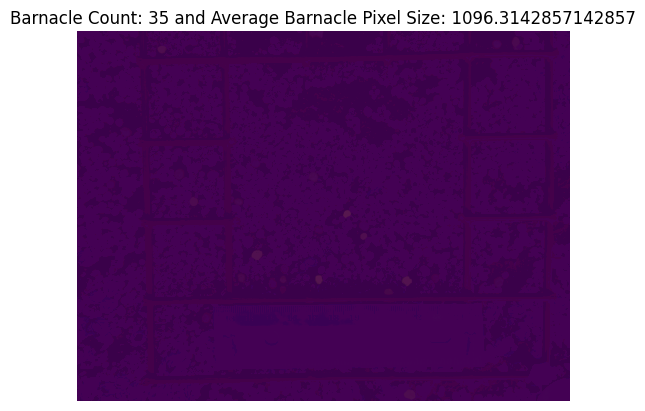

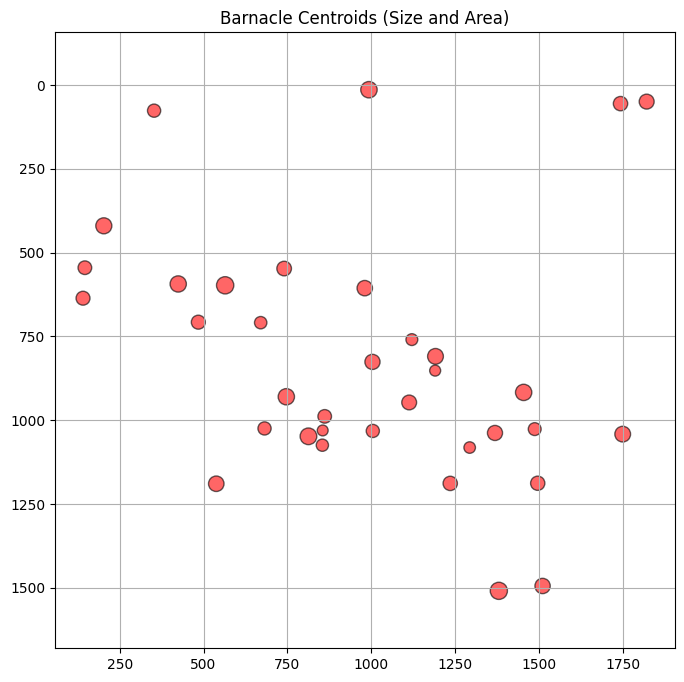

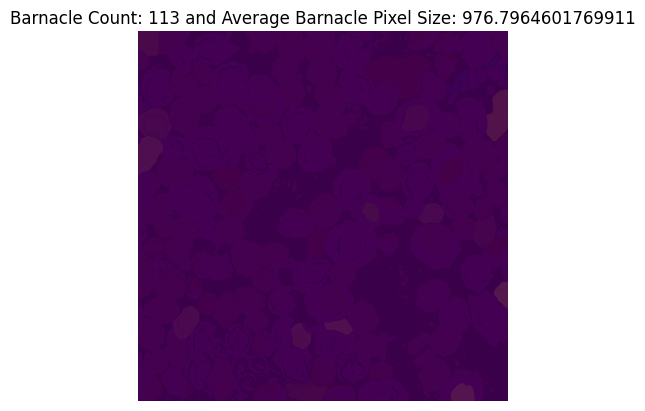

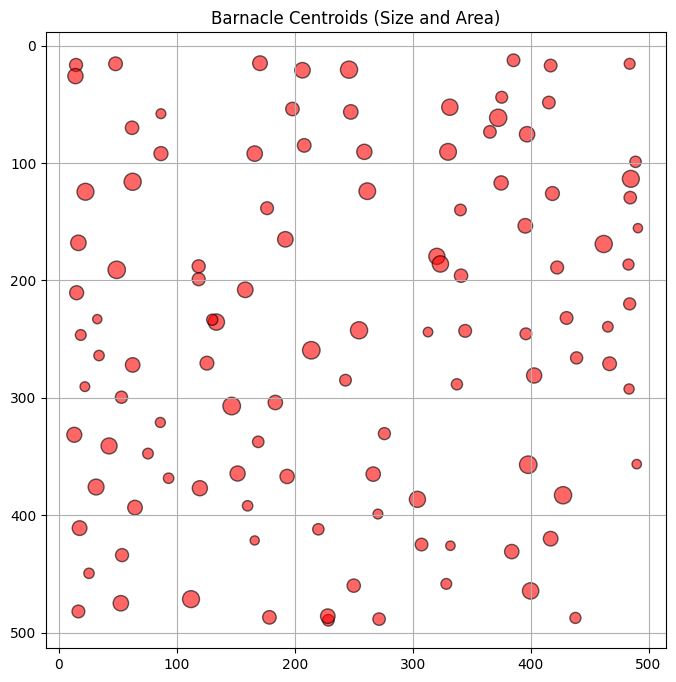

In [75]:
from matplotlib import pyplot as plt

# funtion takes barnacle image and returns
# number of barnacles counted by SAM model
def count_barnacles(img_path):
    image = load_and_resize(img_path, max_dim=2048)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # create mask using SAM
    masks = mask_generator.generate(image)

    # filter, count, and calculate average size of valid barnicles
    barnacle_masks = []
    barnacle_areas = []
    barnacle_x = []
    barnacle_y = []
    sum = 0
    for m in masks:
      if min_area < np.sum(m['segmentation']) < max_area:
        sum += np.sum(m['segmentation'])
        c_x = m['bbox'][0] + (m['bbox'][2] / 2)
        c_y = m['bbox'][1] + (m['bbox'][3] / 2)
        barnacle_masks.append(m)
        barnacle_areas.append(np.sum(m["segmentation"]))
        barnacle_x.append(c_x)
        barnacle_y.append(c_y)

    # calculate count and average
    count = len(barnacle_masks)
    average = sum / count


    # shows the mask created. can switch to showing orignal image.
    plt.imshow(image)
    for m in barnacle_masks:
        plt.imshow(m['segmentation'], alpha=0.10)
    plt.title(f"Barnacle Count: {count} and Average Barnacle Pixel Size: {average}")
    plt.axis('off')
    plt.show()

    # plots the masks based on their centers and sizes
    areas = np.array(barnacle_areas)
    # Plot data
    plt.figure(figsize=(8, 8))
    plt.scatter( barnacle_x, barnacle_y,
    s=areas * 0.10,           # Scale point size based on area
    c='red', alpha=0.6, edgecolors='k')
    plt.title("Barnacle Centroids (Size and Area)")
    plt.gca().invert_yaxis()  # flip Y-axis to match image coordinates
    plt.axis('equal')
    plt.grid(True)
    plt.show()

    return count

# Run on unseen images
count1 = count_barnacles("unseen_img1.png")

# was running into memory issues so clearing GPU cache before running
# counter on second image
import torch
torch.cuda.empty_cache()
count2 = count_barnacles("unseen_img2.png")
